In [1]:
import pandas
import requests

from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score,
)

In [2]:
r = requests.get("https://raw.githubusercontent.com/lutydlitatova/czechitas-datasets/main/datasets/movies.csv")
open("movies.csv", "wb").write(r.content)

9178038

In [3]:
data = pandas.read_csv("movies.csv")
data

,title,genre,text
0,Santa Barbara (2014),romance,"Because of his close friend's betrayal, music ..."
1,Behen Hogi Teri (2017),comedy,"Gattu (Rajkummar Rao) has a problem, he loves ..."
2,The Last Coffin (2003),horror,"In the movie, a strange crossword puzzle start..."
3,Lady Krampus (2016),horror,"It's Christmas time in Cleveland, Ohio and fou..."
4,"""Pandemic"" (2016)",thriller,A deadly virus is unleashed on the fictional n...
...,...,...,...
14903,W.M.D. (2009),thriller,It's 2002; America and the UK are pushing hard...
14904,Laramie Mountains (1952),western,Markham and his men have found gold on the Ind...
14905,"""Tycoon"" (2017)",thriller,"In Miami, a young woman Natalie Boyle gets a s..."
14906,"""Louis Grant"" (2012)",comedy,Louis now has sole responsibility for his nine...


In [4]:
X = data["text"]
y = data["genre"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

<AxesSubplot:>

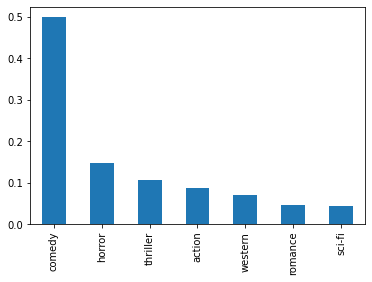

In [5]:
y_train.value_counts(normalize=True).plot(kind="bar")

Pomůžeme si třídou CountVectorizer z balíčku scikit-learn. Můžeme se podívat i na implementaci ve zdrojovém kódu, která není nijak zvlášť složitá: https://github.com/scikit-learn/scikit-learn/blob/0d378913b/sklearn/feature_extraction/text.py#L884

In [6]:
vec = CountVectorizer()
X_train = vec.fit_transform(X_train)
X_test = vec.transform(X_test)

In [7]:
df = pandas.DataFrame.sparse.from_spmatrix(X_train)
df.columns = vec.get_feature_names_out()
df

,00,000,003,007,0074,0077,01,05pm,06,07,...,ł10,ł400,ł500,ł5000,řker,ťgoes,ťknow,ťthe,źs,žš
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11176,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11177,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11178,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11179,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df.sum().sort_values(ascending=False)

the           62607
to            36413
and           36267
of            28203
in            20087
              ...  
jordanians        1
jordaan           1
jor               1
joong             1
žš                1
Length: 49445, dtype: int64

<AxesSubplot:>

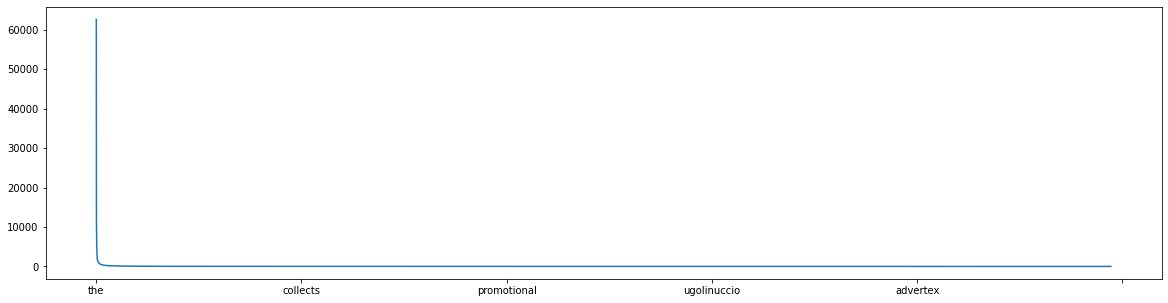

In [9]:
df.sum().sort_values(ascending=False).plot(figsize=(20, 5))